In [1]:

import sys,os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils.pg import PgClass
from src.constants import project_dir, DATABASE_DB, DATABASE_USER, DATABASE_PW, DATABASE_HOST, DATABASE_PORT

import pandas as pd
import numpy as np
import tensorflow as tf

from dateutil.relativedelta import relativedelta
import datetime
import holidays

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import statsmodels.api as sm

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px

from itertools import cycle


import IPython
import IPython.display
from IPython.display import display, HTML, Markdown
from IPython.display import clear_output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x:'%.4f'%x)



In [2]:
pg_conn = PgClass(DATABASE_DB, DATABASE_USER, DATABASE_PW, DATABASE_HOST, DATABASE_PORT)


In [117]:
start_date = '2016-01-01'
#configurations
error = 'mape'
train_start_date_input, train_end_date_input = datetime.date(2016, 1, 1), datetime.date(2021,1,13)
n_forecast =90
n_input_width=30
# take_log = False #whether to take log of the original time series before doing difference
# shift_leading_indicators = True # whether to shift the leading indicators in the time series
# shift_order_leading_indicators = 5
# print_stationarity = False
# graph_residual = True
# print_model_summary = False
# show_adfuller = False


In [4]:
leading_q = f"""
SELECT fc.metric, activity_date, value, frequency, title
FROM fred.fact_metric fc
JOIN fred.dim_metric dim
ON fc.metric = dim.metric
WHERE activity_date >='{start_date}'
AND fc.metric in ('T10YFF', 'DGS10','SP500', 'M2','UMCSENT',
             'PERMIT', 'NEWY636BPPRIV', 'NYBPPRIVSA',
             'ANDENO', 'ACOGNO', 'AMTMNO', 'ACDGNO', 'DGORDER',
             'AWHMAN', 'AWHAETP', 'AWHAEMAN',
             'DTCDISA066MSFRBNY',
             --'ICSA', 
             'MDSP', 'DRSFRMACBS', 'M0264AUSM500NNBR');
             """
leading_df = pd.read_sql_query(leading_q, pg_conn.connection)

In [5]:
etf_q = f"""
select ticker, activity_date, close
from stock.fact_stock_price
where activity_date >='{start_date}'
 and ticker in ('VOX', 'VCR', 'VDC', 'VDE', 'VFH', 'VHT', 'VIS', 'VGT', 'VAW', 'VNQ', 'VPU','QQQ')"""
etf_df = pd.read_sql_query(etf_q, pg_conn.connection)

In [6]:
# pivots the leading indicators and etf to predict
leading_metric_df = leading_df.groupby(['metric','frequency','title']
                                      ).count().index.to_frame(index=False, name=['metric','frequency','title'])
leading_pivoted = pd.pivot_table(leading_df, index='activity_date', columns='metric', values='value',aggfunc='sum').reset_index()

etf_pivoted = pd.pivot_table(etf_df, index='activity_date',columns='ticker',values='close',aggfunc='sum').reset_index()


In [118]:
data_df = etf_pivoted.merge(leading_pivoted, on=['activity_date'], how='outer')\
            .sort_values(by=['activity_date'])\
            .reset_index(drop=True)

In [119]:
data_df = data_df.set_index('activity_date').asfreq('D')
data_df.index = data_df.index.date
etf_list = etf_df.ticker.unique().tolist()
# TODO:
etf_list=['VFH']
leading_metric_list = leading_metric_df.metric.unique().tolist()
# replace the fred metric with 0 value to null
data_df = data_df.replace(0,np.nan)
# forwardfill then backwardfill null value to fill all null value
data_df = data_df.fillna(method='ffill').dropna()

In [120]:
# create date_features
data_df['weekday']=data_df.index.map(lambda x:x.weekday())
data_df['is_weekend'] = np.where(data_df['weekday'].isin([0,6]),1,0)
us_holidays = holidays.UnitedStates()
data_df['is_holiday']=data_df.index.map(lambda x: 1 if x in us_holidays else 0)
date_feature_list = ['weekday','is_weekend','is_holiday']

## Explore

In [10]:
def plot_trends(df):
    for i in df.columns:
        plt.figure(figsize=(6,2))
        plt.plot(df.index, df[i])
        plt.title(i)
        plt.show()

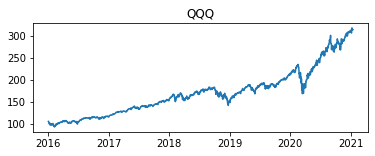

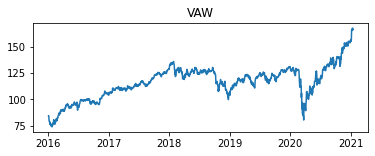

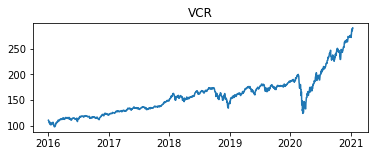

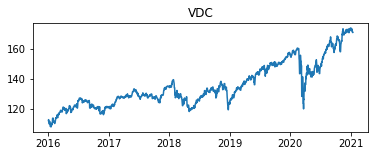

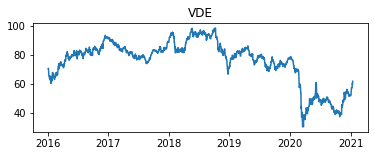

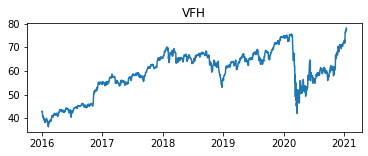

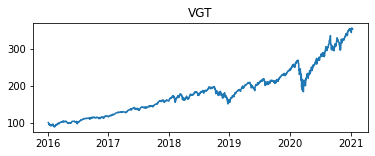

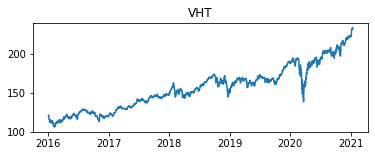

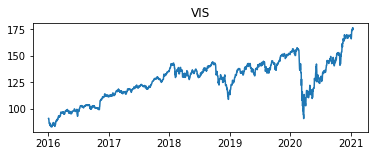

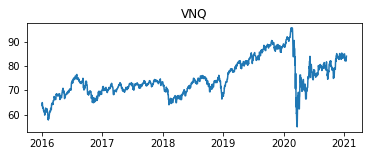

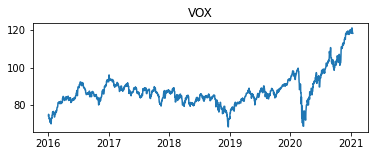

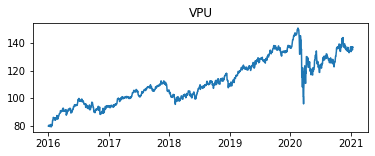

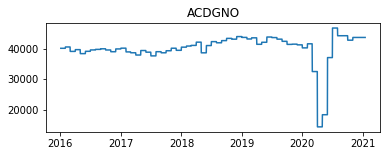

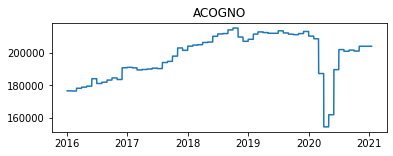

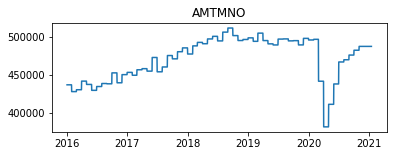

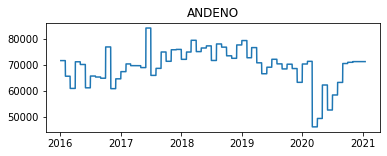

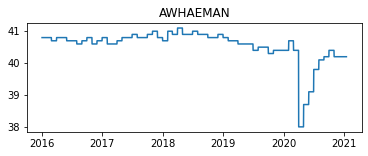

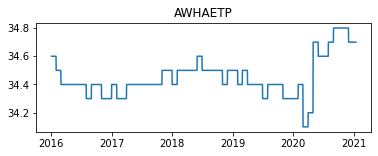

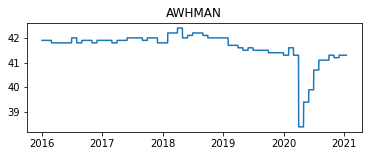

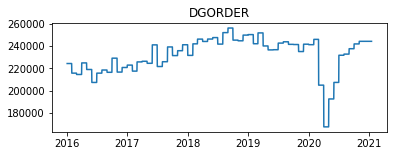

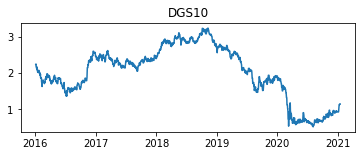

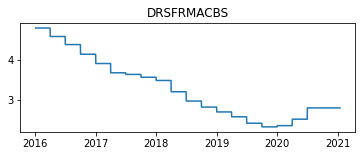

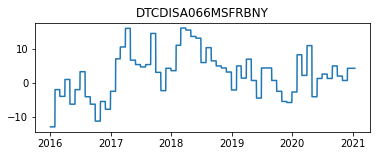

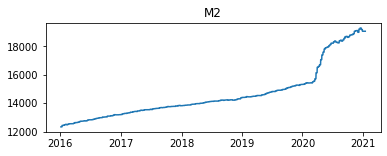

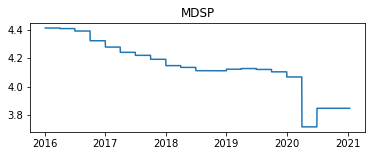

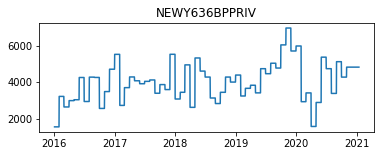

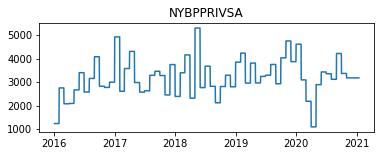

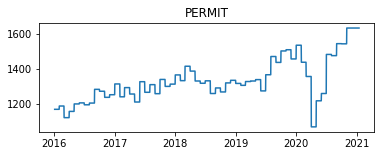

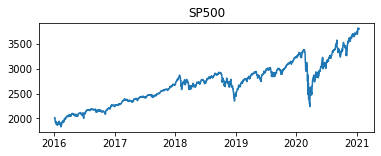

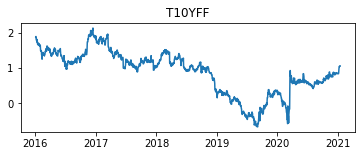

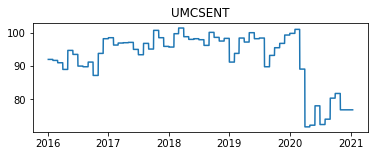

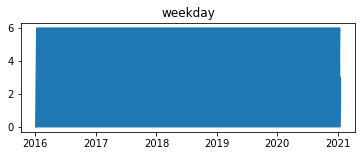

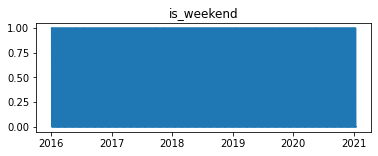

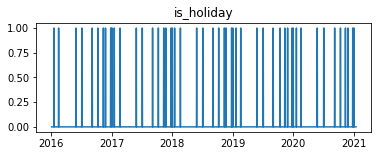

In [11]:
plot_trends(data_df)

<AxesSubplot:>

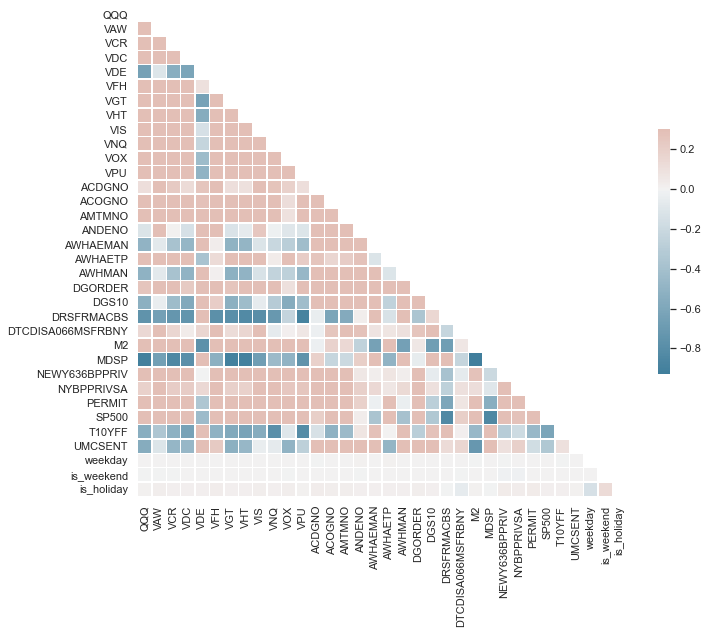

In [12]:
sns.set_theme(style="white")


# Compute the correlation matrix
corr = data_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [13]:
# corr[target_etf].sort_values()

In [121]:
# use related data for model
data_start_date = data_df.index.min()
data_end_date = data_df.index.max()
train_start_date = max(data_start_date, train_start_date_input) 
train_end_date = min(data_end_date, train_end_date_input)
forecast_start_date, forecast_end_date = train_end_date+relativedelta(days=1), train_end_date+relativedelta(days=1+n_forecast)
# 'VOX', 'VCR', 'VDC', 'VDE', 'VFH', 'VHT', 'VIS', 'VGT', 'VAW', 'VNQ', 'VPU'
target_etf = 'VFH'
df = data_df.loc[(data_df.index>= train_start_date) & (data_df.index<= train_end_date),
             etf_list+leading_metric_list+date_feature_list].copy()


## VAR

In [15]:
# diff_order = 1
# diff_df = df.diff(diff_order).dropna()
# diff_df.columns = [ i +'_diff' for i in diff_df.columns]

In [16]:
# # Stationary test
# def adfuller_test(series, signif=0.05, name='', verbose=False):
#     """Perform ADFuller to test for Stationarity of given series and print report"""
#     r = adfuller(series, autolag='AIC')
#     output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
#     p_value = output['pvalue'] 
#     def adjust(val, length= 6): return str(val).ljust(length)

#     # Print Summary
#     print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
#     print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
#     print(f' Significance Level    = {signif}')
#     print(f' Test Statistic        = {output["test_statistic"]}')
#     print(f' No. Lags Chosen       = {output["n_lags"]}')

#     for key,val in r[4].items():
#         print(f' Critical value {adjust(key)} = {round(val, 3)}')

#     if p_value <= signif:
#         print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
#         print(f" => Series is Stationary.")
#     else:
#         print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
#         print(f" => Series is Non-Stationary.")  

# for name, column in diff_df.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

In [17]:
# def test_stationarity(timeseries, label, title):
#     '''
#     function to test  stationary
#     '''
#     #Determing rolling statistics
#     rolmean = timeseries.rolling(window=7).mean()
#     rolstd = timeseries.rolling(window=7).std()

#     #Plot rolling statistics:
#     plt.figure(figsize=(10,6))
#     orig = plt.plot(timeseries, color='black',label=label)
#     #mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     #std = plt.plot(rolstd, color='green', label = 'Rolling Std')
#     plt.xticks(rotation=90)
#     plt.legend(loc='best')
#     plt.title(title)
#     plt.show()
    
#     #Perform Dickey-Fuller test:
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in list(dftest[4].items()):
#         dfoutput['Critical Value (%s)'%key] = value
#     if dfoutput['p-value']<=0.05:
#         conclusion = "stationary"
#     else:
#         conclusion = "not stationary"
#     print("Dickey-Fuller Test: " + conclusion)
#     dfoutput = dfoutput.reset_index()
#     dfoutput.columns=['metric', 'value']
#     display(HTML(dfoutput.to_html()))
    
#     return


In [18]:
# _ = diff_df
# for col in _.columns:
#     print(col)
#     test_stationarity(_[col], label=col, title='first order difference series')


## VAR model

In [19]:

# train_df_var = diff_df[[target_etf+"_diff"]+[i+'_diff' for i in leading_metric_list]].copy()

# model = VAR(train_df_var)
# aic, bic = [], []

# x = np.arange(7)
# for i in x:
#     result = model.fit(i)
#     aic.append(result.aic)
#     bic.append(result.bic)

# plt.figure(figsize=(8,6))
# plt.plot(x, aic, label='aic')
# plt.plot(x, bic, label='bic')
# plt.xlabel("number of lags", fontsize=15)
# plt.legend()
# plt.show()


In [20]:
# maxlags = 7
# model_result_var = model.fit(maxlags=maxlags, ic = 'aic', trend = 'c')  #do not use linear trend since it stationarized after differencing
# num_lag_chosen = model_result_var.k_ar
# print(num_lag_chosen)

# print(model_result_var.summary())


## Tensorflow Models

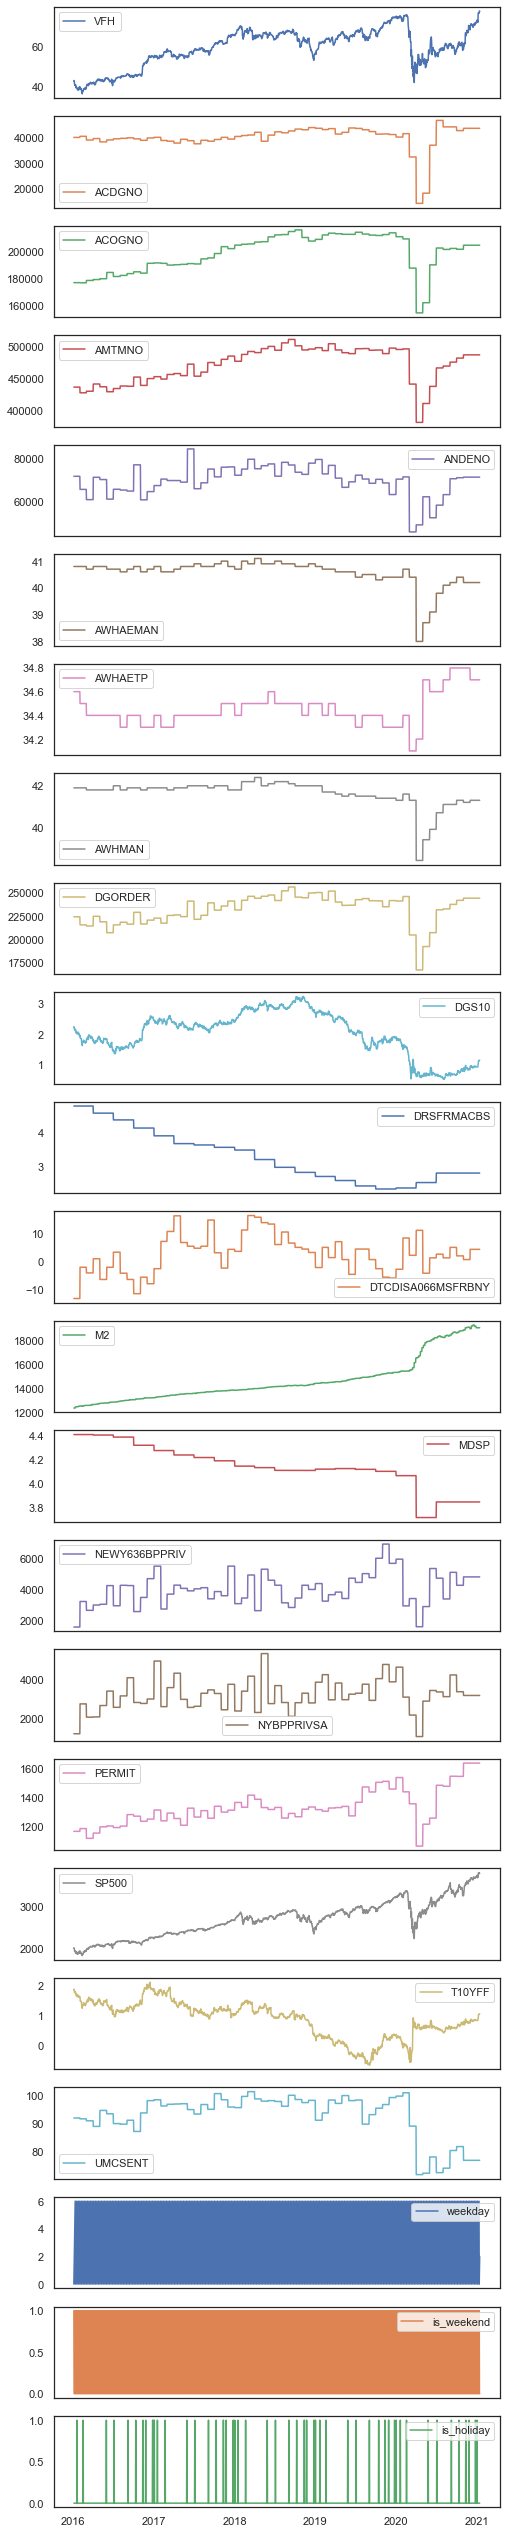

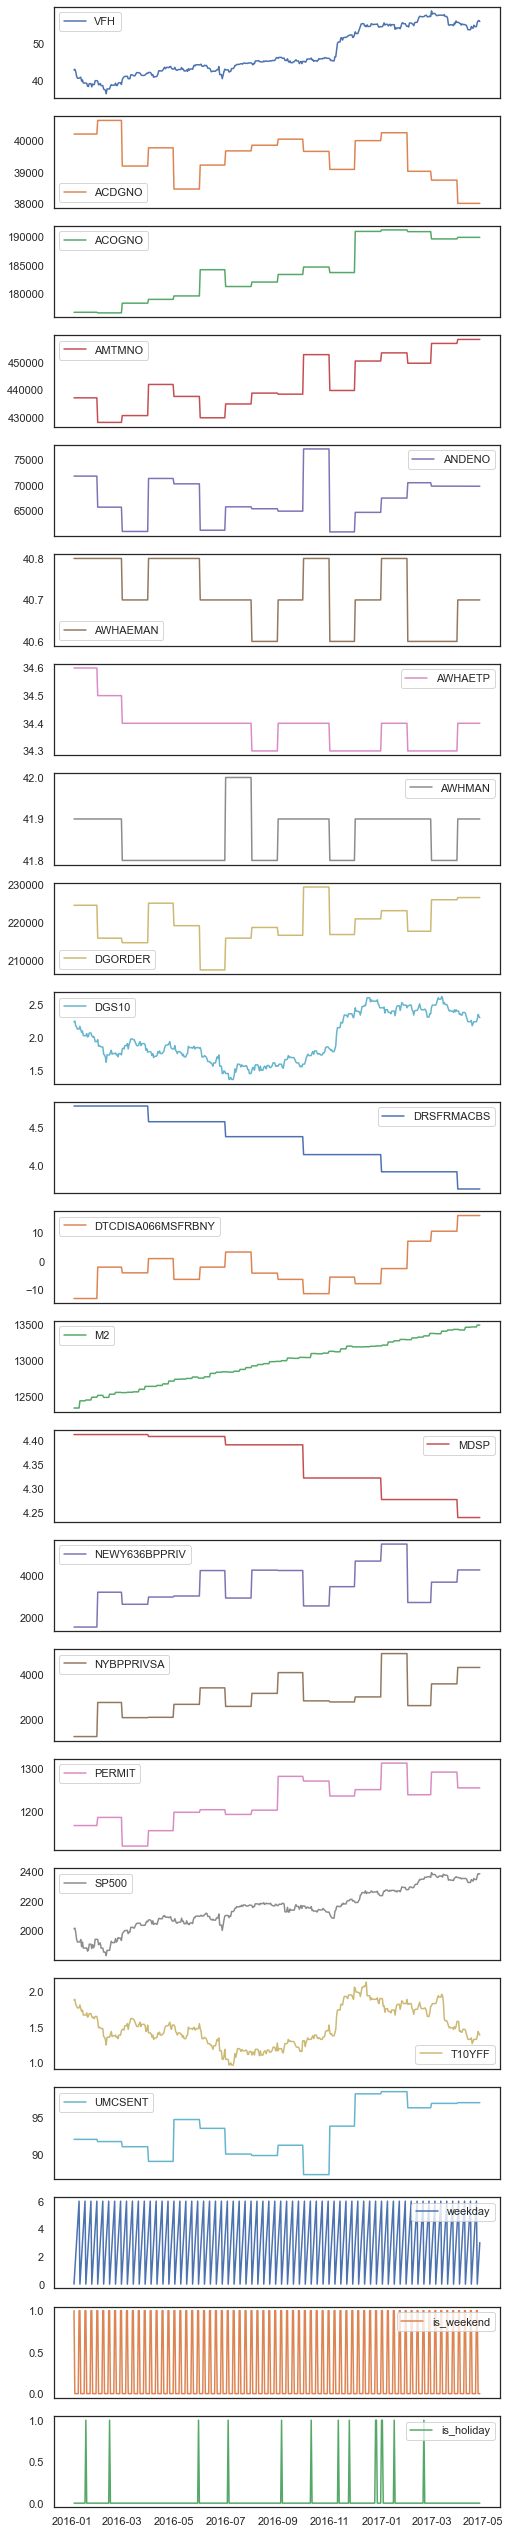

In [257]:

plot_cols = etf_list+leading_metric_list+date_feature_list
mpl.rcParams['figure.figsize'] = (8, len(plot_cols)*2)
mpl.rcParams['axes.grid'] = False

plot_features = df[plot_cols]
# plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
# plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

mpl.rcParams['figure.figsize'] = (8, 6)


In [258]:
df.describe().transpose()


count        mean        std         min         25%  \
VFH               1837.0000     59.1549     9.2598     36.3279     54.7728   
ACDGNO            1837.0000  40205.1089  4995.8428  14373.0000  39228.0000   
ACOGNO            1837.0000 198295.0572 13987.9610 154232.0000 189822.0000   
AMTMNO            1837.0000 471158.9494 27628.7692 382304.0000 450403.0000   
ANDENO            1837.0000  69676.4045  6976.6912  46151.0000  66049.0000   
AWHAEMAN          1837.0000     40.5583     0.5208     38.0000     40.4000   
AWHAETP           1837.0000     34.4500     0.1386     34.1000     34.4000   
AWHMAN            1837.0000     41.6300     0.6497     38.4000     41.5000   
DGORDER           1837.0000 232265.5073 15917.7143 167502.0000 223046.0000   
DGS10             1837.0000      2.0158     0.7251      0.5200      1.6000   
DRSFRMACBS        1837.0000      3.2830     0.7473      2.3400      2.7100   
DTCDISA066MSFRBNY 1837.0000      2.6519     6.5755    -13.0000     -2.3000   
M2                1837.0000  14628.7381  1807.1392  12342.8000  13431.8000   
MDSP              1837.0000      4.1430     0.1801      3.7158      4.1034   
NEWY636BPPRIV     1837.0000   4018.9505  1059.0288   1549.0000   3241.0000   
NYBPPRIVSA        1837.0000   3206.7825   794.3583   1099.1502   2773.0285   
PERMIT            1837.0000   1330.1704   121.8433   1066.0000   1257.0000   
SP500             1837.0000   2692.2794   433.0511   1829.0800   2365.3800   
T10YFF            1837.0000      0.8705     0.6096     -0.6600      0.4600   
UMCSENT           1837.0000     92.7081     7.9834     71.8000     90.0000   
weekday           1837.0000      2.9967     2.0008      0.0000      1.0000   
is_weekend        1837.0000      0.2858     0.4519      0.0000      0.0000   
is_holiday        1837.0000      0.0299     0.1705      0.0000      0.0000   

                          50%         75%         max  
VFH                   61.1359     65.9339     77.5400  
ACDGNO             40655.0000  42885.0000  46888.0000  
ACOGNO            202290.0000 210684.0000 215709.0000  
AMTMNO            480291.0000 494737.0000 511193.0000  
ANDENO             70641.0000  73623.0000  84363.0000  
AWHAEMAN              40.7000     40.8000     41.1000  
AWHAETP               34.4000     34.5000     34.8000  
AWHMAN                41.8000     42.0000     42.4000  
DGORDER           236884.0000 244018.0000 256401.0000  
DGS10                  2.1500      2.5500      3.2400  
DRSFRMACBS             2.9800      3.6800      4.7900  
DTCDISA066MSFRBNY      3.2000      6.0000     16.2000  
M2                 14142.0000  15110.5000  19299.0000  
MDSP                   4.1266      4.2407      4.4120  
NEWY636BPPRIV       4044.0000   4738.0000   6967.0000  
NYBPPRIVSA          3186.4018   3686.6278   5312.8809  
PERMIT              1316.0000   1387.0000   1635.0000  
SP500               2713.2200   2945.3500   3824.6800  
T10YFF                 1.0100      1.3100      2.1300  
UMCSENT               95.7000     98.2000    101.4000  
weekday                3.0000      5.0000      6.0000  
is_weekend             0.0000      1.0000      1.0000  
is_holiday             0.0000      0.0000      1.0000

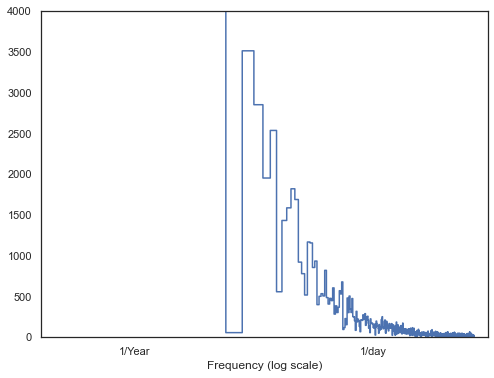

In [259]:
# determine which frequencies are important using an fft
fft = tf.signal.rfft(df[target_etf])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df[target_etf])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 4000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [260]:
# split data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


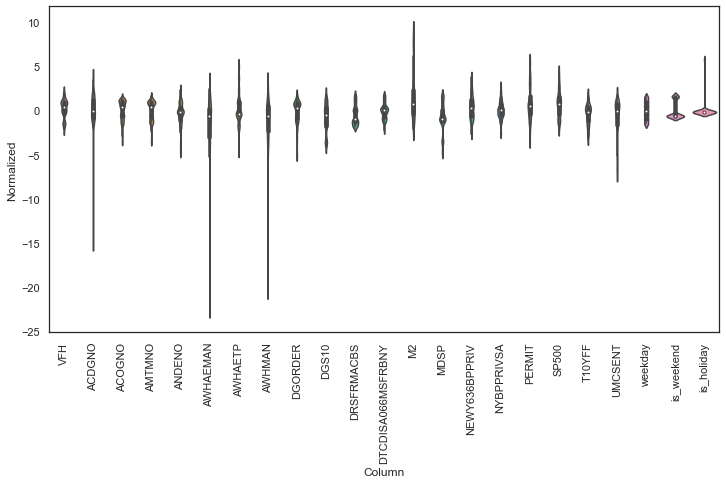

In [261]:
# normalize data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# check distribution
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [262]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(train_df)

# train_mean = scaler.mean_
# train_std = scaler.var_

# train_df = scaler.transform(train_df)
# val_df = scaler.transform(val_df)
# test_df = scaler.transform(test_df)

# # check distribution
# df_std = scaler.transform(df_std)
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)

In [263]:
# generate window
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [264]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=[target_etf])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['VFH']

In [265]:
w2 = WindowGenerator(input_width=n_input_width, label_width=1, shift=1,
                     label_columns=[target_etf])
w2

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['VFH']

In [266]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [267]:
# Stack three slices, the length of the total window:
example_window = tf.stack([
    
                           np.array(train_df[-6*w2.total_window_size:-5*w2.total_window_size]),
    
                           np.array(train_df[-5*w2.total_window_size:-4*w2.total_window_size]),
    
                           np.array(train_df[-4*w2.total_window_size:-3*w2.total_window_size]),
    np.array(train_df[-3*w2.total_window_size:-2*w2.total_window_size]),
                           np.array(train_df[-2*w2.total_window_size:-w2.total_window_size]),
                           np.array(train_df[-w2.total_window_size:])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (6, 31, 23)
Inputs shape: (6, 30, 23)
labels shape: (6, 1, 1)


In [268]:
w2.example = example_inputs, example_labels


In [347]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Date [d]')

WindowGenerator.plot = plot

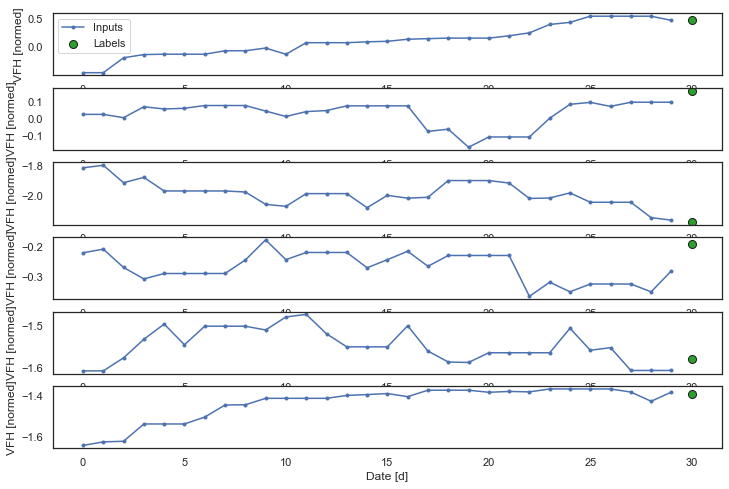

In [348]:
w2.plot(plot_col=target_etf,max_subplots=6)

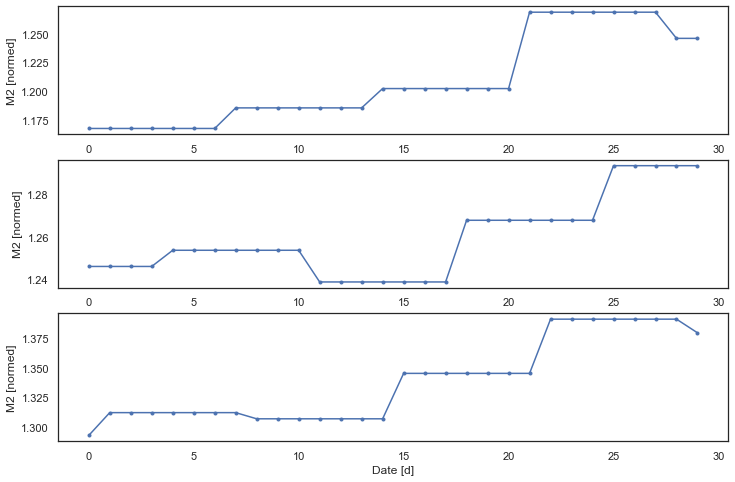

In [271]:
w2.plot(plot_col='M2')


In [272]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [273]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [274]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 30, 23), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [275]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 23)
Labels shape (batch, time, features): (32, 1, 1)


In [276]:
single_step_window = WindowGenerator(
    input_width=n_input_width, label_width=1, shift=1,
    label_columns=[target_etf])
single_step_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['VFH']

In [277]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 23)
Labels shape (batch, time, features): (32, 1, 1)


In [278]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [279]:
# baseline model that use current value
baseline = Baseline(label_index=column_indices[target_etf])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

11/11 [==============================] - 0s 1ms/step - loss: 0.3663 - mean_absolute_error: 0.3571


In [280]:
wide_window = WindowGenerator(
    input_width=n_input_width, label_width=n_input_width, shift=1,
    label_columns=[target_etf])

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['VFH']

In [281]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 30, 23)
Output shape: (32, 30, 1)


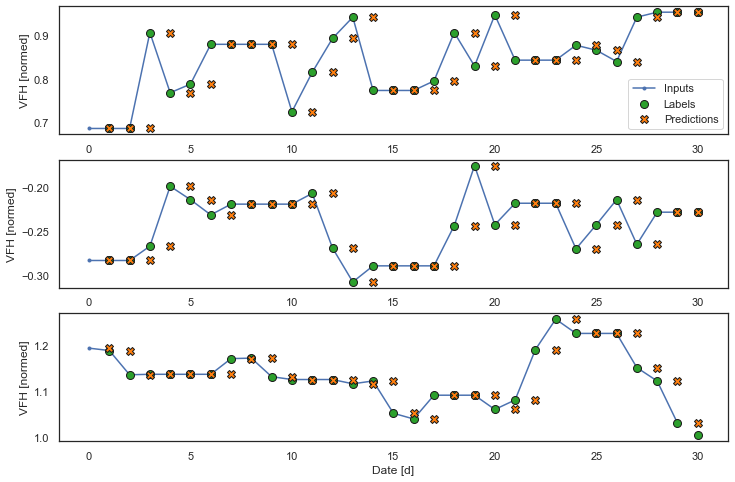

In [282]:
# Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

wide_window.plot(baseline,target_etf)

In [283]:
# Linear model
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [284]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 30, 23)
Output shape: (32, 30, 1)


In [285]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    
    return history

In [286]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
40/40 [==============================] - 1s 8ms/step - loss: 1.7549 - mean_absolute_error: 1.1104 - val_loss: 11.3509 - val_mean_absolute_error: 2.3001
Epoch 2/20
40/40 [==============================] - 0s 5ms/step - loss: 1.2400 - mean_absolute_error: 0.9002 - val_loss: 11.1390 - val_mean_absolute_error: 2.2069
Epoch 3/20
40/40 [==============================] - 0s 5ms/step - loss: 0.9719 - mean_absolute_error: 0.7744 - val_loss: 9.2421 - val_mean_absolute_error: 1.9840
Epoch 4/20
40/40 [==============================] - 0s 5ms/step - loss: 0.7875 - mean_absolute_error: 0.6914 - val_loss: 7.5479 - val_mean_absolute_error: 1.7800
Epoch 5/20
40/40 [==============================] - 0s 5ms/step - loss: 0.6507 - mean_absolute_error: 0.6229 - val_loss: 5.9841 - val_mean_absolute_error: 1.5800
Epoch 6/20
40/40 [==============================] - 0s 5ms/step - loss: 0.5396 - mean_absolute_error: 0.5747 - val_loss: 4.6219 - val_mean_absolute_error: 1.4018
Epoch 7/20
40/40 [========

In [287]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Input shape: (32, 30, 23)
Output shape: (32, 30, 1)


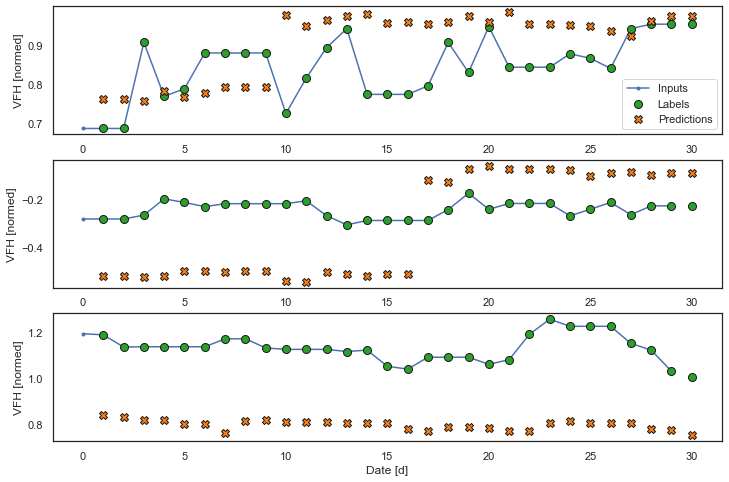

In [288]:
wide_window.plot(linear,target_etf)


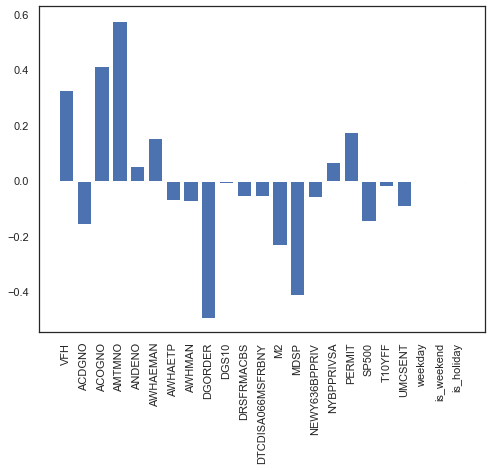

In [289]:
# pull out the layer's weights, and see the weight assigned to each input:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [290]:
# Dense
# checking the performance of deeper, more powerful, single input step models.
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
40/40 [==============================] - 1s 10ms/step - loss: 0.6265 - mean_absolute_error: 0.6091 - val_loss: 4.1286 - val_mean_absolute_error: 1.3713
Epoch 2/20
40/40 [==============================] - 0s 6ms/step - loss: 0.0584 - mean_absolute_error: 0.1823 - val_loss: 4.6765 - val_mean_absolute_error: 1.4862
Epoch 3/20
11/11 [==============================] - 0s 2ms/step - loss: 5.4859 - mean_absolute_error: 1.6299


In [291]:
CONV_WIDTH = n_input_width
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[target_etf])

conv_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['VFH']

Text(0.5, 1.0, 'Given 30d as input, predict 1d into the future.')

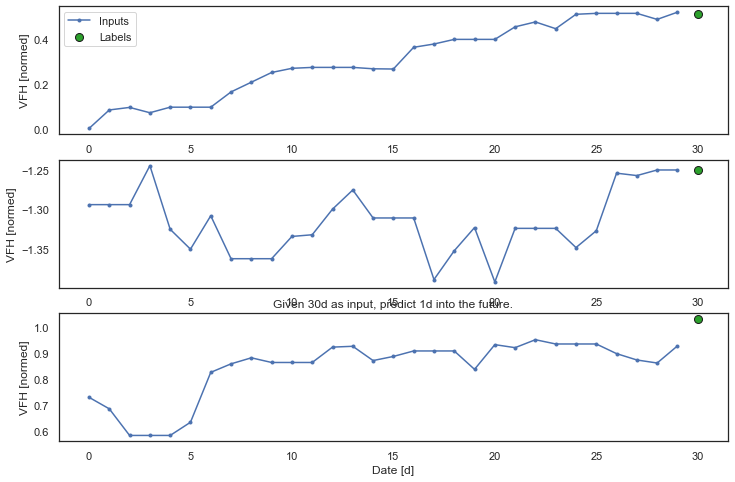

In [292]:
conv_window.plot(plot_col=target_etf)
plt.title(f"Given {n_input_width}d as input, predict 1d into the future.")

In [293]:
# multi step dense
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [294]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 30, 23)
Output shape: (32, 1, 1)


In [295]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

11/11 [==============================] - 0s 2ms/step - loss: 0.5631 - mean_absolute_error: 0.5233


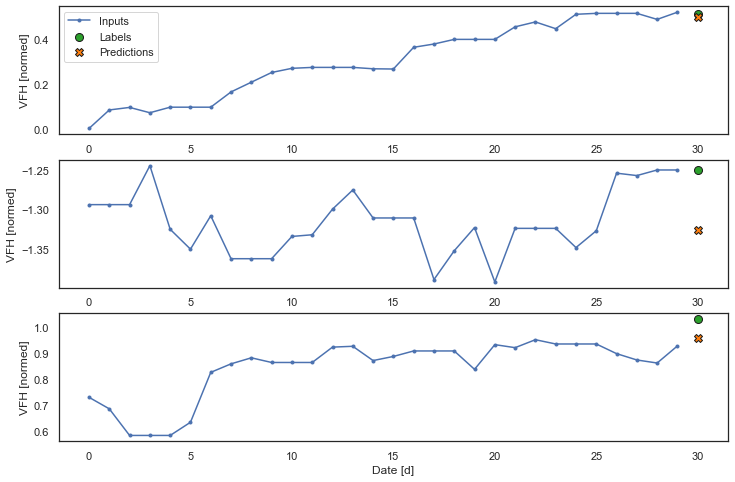

In [296]:
conv_window.plot(multi_step_dense, target_etf)

In [297]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 30, 23)
Output shape: (32, 1, 1)


In [298]:
# Convolution neural network
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [299]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 30, 23)
Output shape: (32, 1, 1)


In [300]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

11/11 [==============================] - 0s 2ms/step - loss: 0.8033 - mean_absolute_error: 0.6682


In [301]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)


Wide window
Input shape: (32, 30, 23)
Labels shape: (32, 30, 1)
Output shape: (32, 1, 1)


In [302]:
LABEL_WIDTH = n_input_width
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=[target_etf])

wide_conv_window

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): ['VFH']

In [303]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 59, 23)
Labels shape: (32, 30, 1)
Output shape: (32, 30, 1)


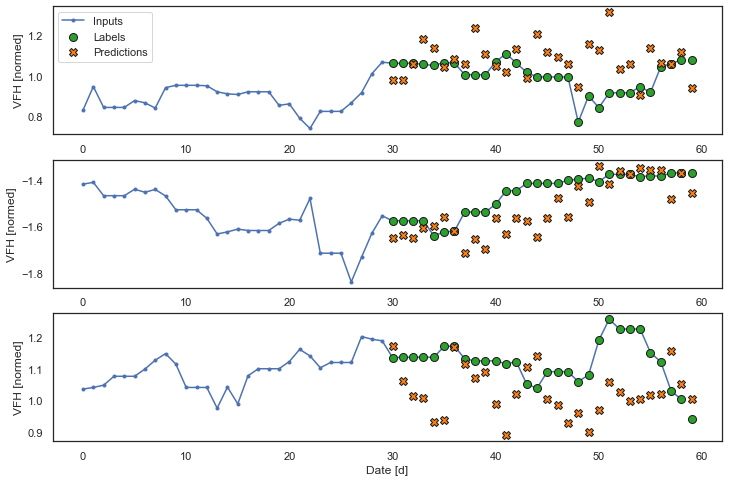

In [304]:
wide_conv_window.plot(conv_model,target_etf)


In [305]:
# Recurrent neural network
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [306]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 30, 23)
Output shape: (32, 30, 1)


In [307]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)


11/11 [==============================] - 0s 4ms/step - loss: 0.4053 - mean_absolute_error: 0.4993


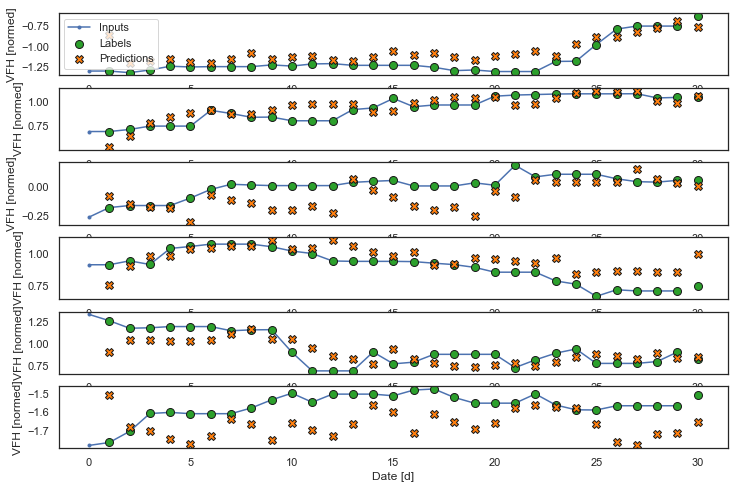

In [349]:
wide_window.plot(lstm_model,target_etf,max_subplots=6)

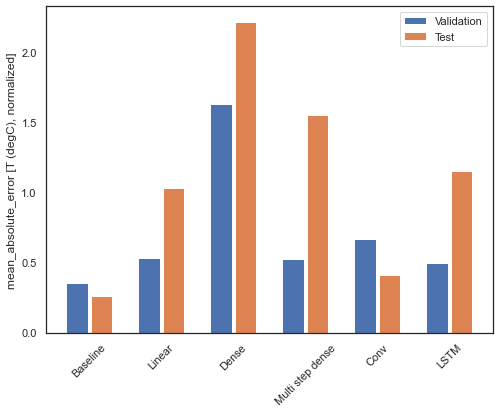

In [309]:
# Performance
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [310]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.2600
Linear      : 1.0276
Dense       : 2.2154
Multi step dense: 1.5481
Conv        : 0.4098
LSTM        : 1.1522


### Single step models

In [311]:
# Multi-output models
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=n_input_width, label_width=n_input_width, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 23)
Labels shape (batch, time, features): (32, 30, 23)


In [312]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [313]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

11/11 [==============================] - 0s 2ms/step - loss: 0.3977 - mean_absolute_error: 0.1239


In [314]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [315]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

12/12 [==============================] - 0s 2ms/step - loss: 5.3814 - mean_absolute_error: 1.3177


In [316]:
%%time
wide_window = WindowGenerator(
    input_width=n_input_width, label_width=n_input_width, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

11/11 [==============================] - 0s 4ms/step - loss: 9.4058 - mean_absolute_error: 1.4776

CPU times: user 25.4 s, sys: 3.97 s, total: 29.4 s
Wall time: 16.7 s


In [317]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [318]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

11/11 [==============================] - 0s 4ms/step - loss: 0.2606 - mean_absolute_error: 0.1213

CPU times: user 13.3 s, sys: 2.19 s, total: 15.5 s
Wall time: 8.91 s


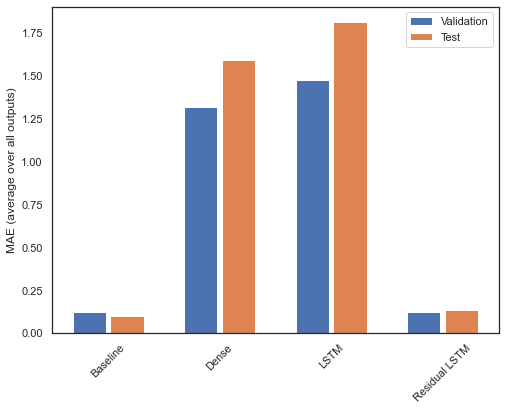

In [319]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [320]:
for name, value in performance.items():
    print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1005
Dense          : 1.5920
LSTM           : 1.8125
Residual LSTM  : 0.1360


## Multi-step models

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): None

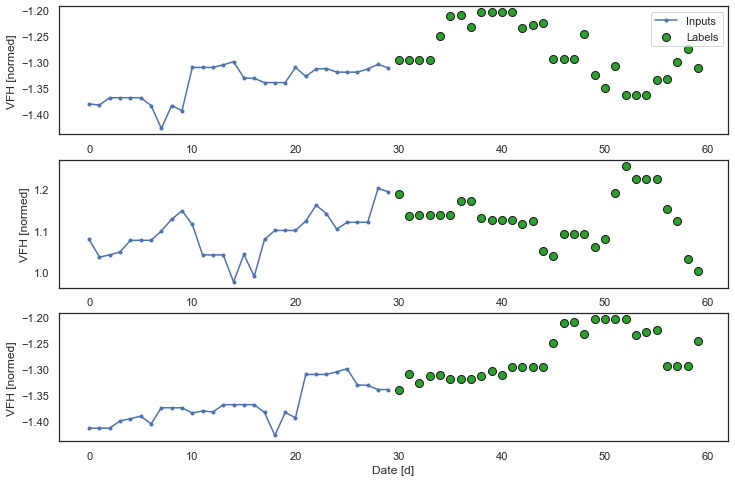

In [321]:
OUT_STEPS = n_input_width
multi_window = WindowGenerator(input_width=n_input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot(plot_col=target_etf)
multi_window

### Baseline

10/10 [==============================] - 0s 2ms/step - loss: 3.5367 - mean_absolute_error: 0.6835


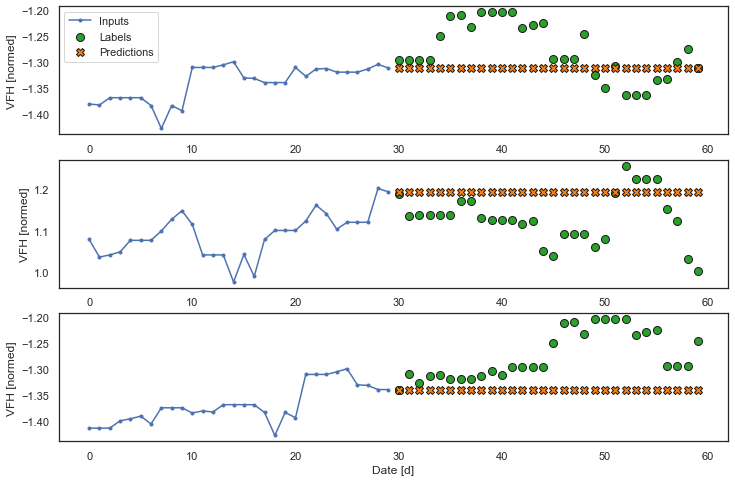

In [322]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline, plot_col=target_etf)

10/10 [==============================] - 0s 2ms/step - loss: 6.0856 - mean_absolute_error: 1.1940


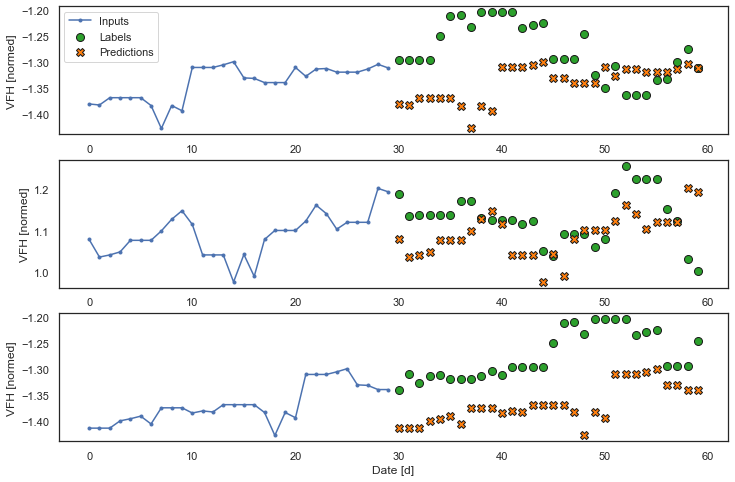

In [323]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline, plot_col=target_etf)

### Single-shot models

10/10 [==============================] - 0s 2ms/step - loss: 6.5364 - mean_absolute_error: 1.3518


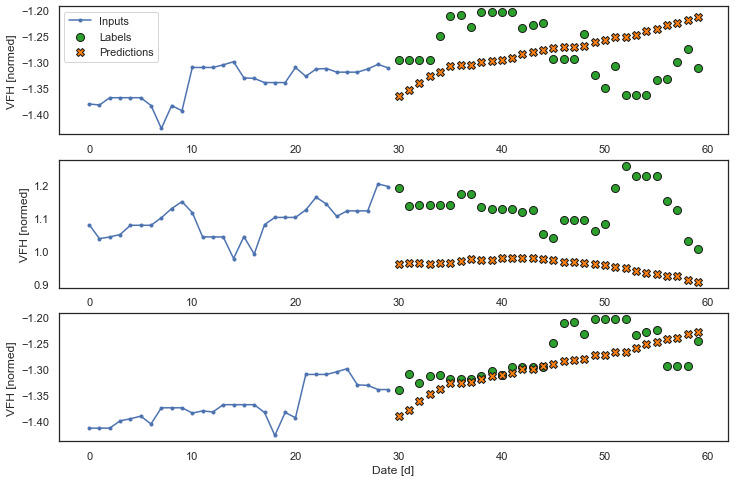

In [324]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model, plot_col=target_etf)

### Dense

10/10 [==============================] - 0s 3ms/step - loss: 5.8184 - mean_absolute_error: 1.2718


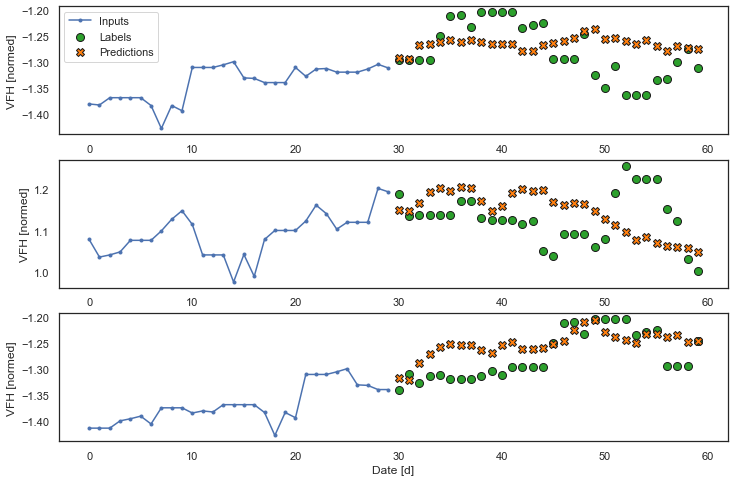

In [325]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model, plot_col=target_etf)

10/10 [==============================] - 0s 2ms/step - loss: 6.1008 - mean_absolute_error: 1.2739


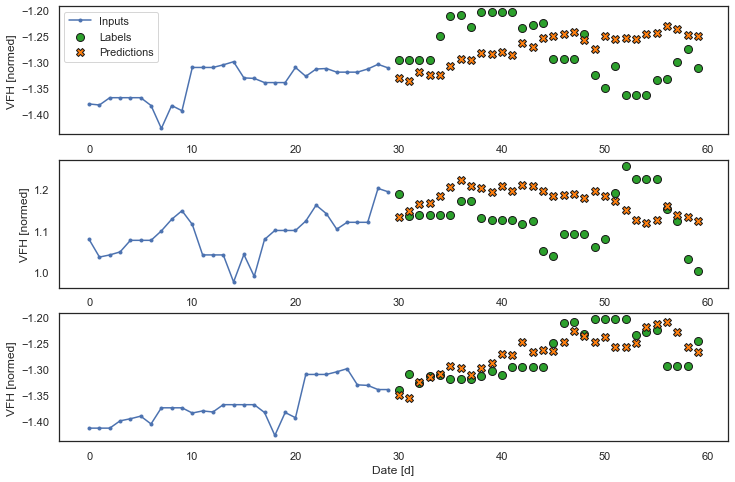

In [326]:
# CNN
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model, plot_col=target_etf)

10/10 [==============================] - 0s 3ms/step - loss: 11.2284 - mean_absolute_error: 1.7818


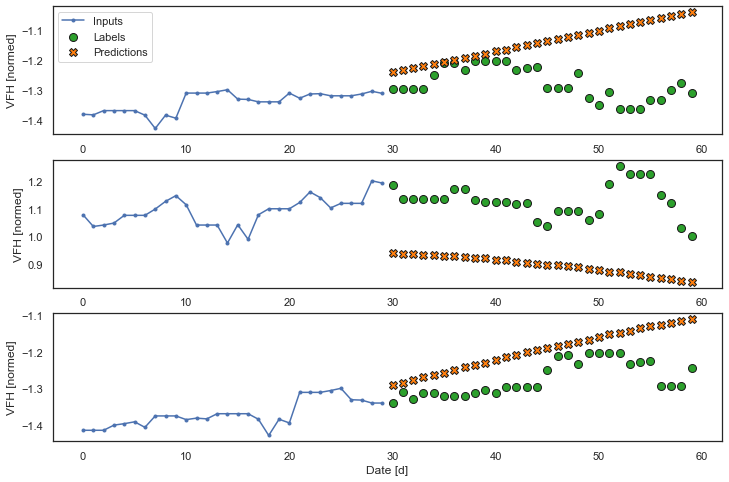

In [327]:
# RNN
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model, plot_col=target_etf)

### Advanced: Autoregressive model

In [328]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [329]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [330]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [331]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 23])

In [332]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [333]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 30, 23)


10/10 [==============================] - 0s 6ms/step - loss: 11.2705 - mean_absolute_error: 1.8504


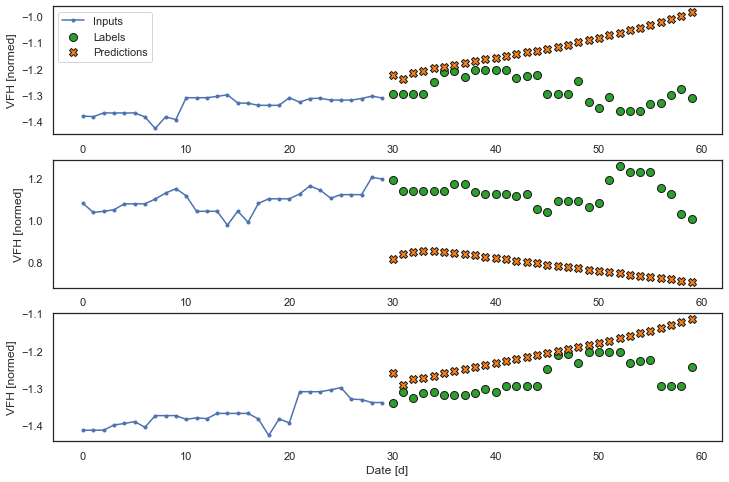

In [334]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model, plot_col=target_etf)

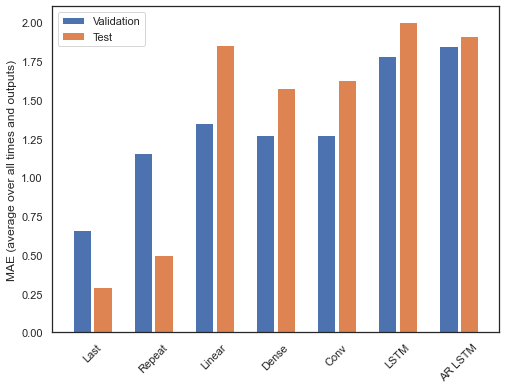

In [335]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [336]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.2936
Repeat  : 0.4977
Linear  : 1.8562
Dense   : 1.5792
Conv    : 1.6290
LSTM    : 2.0034
AR LSTM : 1.9124


### Predict

In [372]:

actual_df_std = (df - train_mean) / train_std
predictions = multi_dense_model.predict(w2.make_dataset(data=actual_df_std))
print("predictions shape:", predictions.shape)   

predictions shape: (1807, 30, 23)


In [373]:
predictions_reversed = pd.DataFrame(data = predictions[0],columns=plot_cols)
predictions_reversed = predictions_reversed*train_std+train_mean
predictions_reversed.index = pd.date_range(forecast_start_date,periods=predictions_reversed.shape[0],freq='D').date

In [374]:

current = df[etf_list].tail(1).values
future = np.array(predictions_reversed[etf_list].mean())
# future = predictions_reversed[etf_list].tail(1).values


In [375]:
pd.DataFrame(data={'etf':etf_list,'% change':(future/current-1)[0]})

etf  % change
0  VFH   -0.1497

In [376]:
final_actual = df[etf_list+leading_metric_list].copy()
final_actual['Type'] = 'Actual'
final_pred = predictions_reversed[etf_list+leading_metric_list].copy()
final_pred['Type'] = 'Prediction'

final_df = final_actual.append(final_pred)
final_df['Created Date']=train_end_date

In [377]:
# final_df.to_csv(os.path.join(project_dir, f'data/processed/ts_leading_metric_impact_on_sectors_pred_{train_end_date}.csv'), encoding='utf-8', index=False)


In [378]:
# colors
palette = cycle(px.colors.qualitative.Bold)

max_y = final_df[etf_list].max().max()
n_digit = 10 ** (len(str(int(max_y)))-1)
data = []
for etf in etf_list:
    trace_color = next(palette)
    trace_actual = go.Scatter(x=final_actual.index, y=final_actual[etf],
                    mode='lines',
                    name=f'{etf}-actual',
                             line=go.Line(color=trace_color,
                                         width=1.5,))
    trace_pred = go.Scatter(x=final_pred.index, y=final_pred[etf],
                    mode='lines',
                    name=f'{etf}-prediction',
                           line=go.Line(color=trace_color,
                                       width=1.5,
                                       dash='dashdot'))
    data.append(trace_actual)
    data.append(trace_pred)

layout = go.Layout(title='ETF',
                  xaxis=dict(title='Date'),
                  yaxis=dict(title='Value'))
layout.update(dict(shapes=[
    {
        'type':'line',
        'x0':train_end_date,
        'y0':0,
        'x1':train_end_date,
        'y1':np.ceil(max_y/n_digit)*n_digit,
        'line':{
            'color':'#909090',
            'width':1
        }
        
    }
]))
layout.update(dict(annotations=[
    go.Annotation(text='End of training',
                 x=train_end_date,
                 y=np.floor(max_y/n_digit)*n_digit
                  )
]))
fig = go.Figure(data = data,layout=layout)

fig.show()

/Users/yilin/Documents/Projects/market_analysis/market_analysis/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/Users/yilin/Documents/Projects/market_analysis/market_analysis/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:149: DeprecationWarning:

plotly.graph_objs.Annotation is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Annotation
  - plotly.graph_objs.layout.scene.Annotation




In [379]:


# colors
palette = cycle(px.colors.qualitative.Vivid)

max_y = final_df[leading_metric_list].max().max()
n_digit = 10 ** (len(str(int(max_y)))-1)
data = []
for leading_metric in leading_metric_list:
    trace_color = next(palette)
    trace_actual = go.Scatter(x=final_actual.index, y=final_actual[leading_metric],
                    mode='lines',
                    name=f'{leading_metric}-actual',
                             line=go.Line(color=trace_color,
                                         width=1.5,))
    trace_pred = go.Scatter(x=final_pred.index, y=final_pred[leading_metric],
                    mode='lines',
                    name=f'{leading_metric}-prediction',
                           line=go.Line(color=trace_color,
                                       width=1.5,
                                       dash='dashdot'))
    data.append(trace_actual)
    data.append(trace_pred)

layout = go.Layout(title='Leading Metrics',
                  xaxis=dict(title='Date'),
                  yaxis=dict(title='Value'))
layout.update(dict(shapes=[
    {
        'type':'line',
        'x0':train_end_date,
        'y0':0,
        'x1':train_end_date,
        'y1':np.ceil(max_y/n_digit)*n_digit,
        'line':{
            'color':'#909090',
            'width':1
        }
        
    }
]))
layout.update(dict(annotations=[
    go.Annotation(text='End of training',
                 x=train_end_date,
                 y=np.floor(max_y/n_digit)*n_digit
                  )
]))
fig = go.Figure(data = data,layout=layout)

fig.show()